In [30]:
# Imports and plotting setups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import sys, os
sys.path.insert(0, '../../')
sys.path.insert(0, '../')

import math_funcs

from cycler import cycler

default_cycler = (cycler(color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', 'black']) +
                cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':']))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 8

plt.rcParams['figure.figsize'] = (3.5, 2.5)
plt.rcParams['figure.dpi'] = 200

#plt.rcParams['text.usetex'] = True

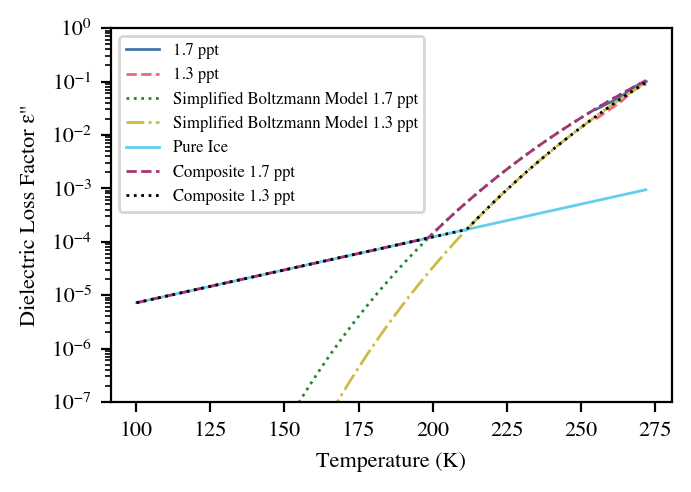

In [31]:
# Values from Vant 1976 PhD Thesis, and read from graph in Hallikainen 1992
temp_loss_factor = 273.15 + np.array([-18, -10, -5, -1])
loss_factor_sal_1p7ppt = [0.03, 0.05, 0.08, 0.10]
loss_factor_sal_1p3ppt = [0.02, 0.04, 0.07, 0.09]

fig = plt.figure()

plt.plot(temp_loss_factor, loss_factor_sal_1p7ppt, label='1.7 ppt')
plt.plot(temp_loss_factor, loss_factor_sal_1p3ppt, label='1.3 ppt')

temp_act_energy = np.arange(100, 273, 1)
boltzmann_model = lambda ae, t_0, epsilon_0, t: epsilon_0 * np.e**((ae* scipy.constants.electron_volt / scipy.constants.Boltzmann) \
    * (1 / (t_0) - (1 / (t))))
dielectric_loss_factor_1p7ppt = boltzmann_model(0.43, #eV
    273.15 - 5, 0.08, temp_act_energy)
dielectric_loss_factor_1p3ppt = boltzmann_model(0.52, #eV
    273.15 - 5, 0.07, temp_act_energy)
pure_ice_loss_factor = 10**(-3.0129 + 0.0123 * (temp_act_energy - 273.15))

plt.plot(temp_act_energy, dielectric_loss_factor_1p7ppt, label='Simplified Boltzmann Model 1.7 ppt')
plt.plot(temp_act_energy, dielectric_loss_factor_1p3ppt, label='Simplified Boltzmann Model 1.3 ppt')
plt.plot(temp_act_energy, pure_ice_loss_factor, label='Pure Ice')
plt.plot(temp_act_energy, np.maximum(pure_ice_loss_factor, dielectric_loss_factor_1p7ppt), label='Composite 1.7 ppt')
plt.plot(temp_act_energy, np.maximum(pure_ice_loss_factor, dielectric_loss_factor_1p3ppt), label='Composite 1.3 ppt')
plt.xlabel('Temperature (K)')
plt.ylabel('Dielectric Loss Factor ε\'\'')
plt.yscale('log')
plt.ylim(10**-7, 1)
plt.legend(fontsize=6)
plt.tight_layout()
plt.show()


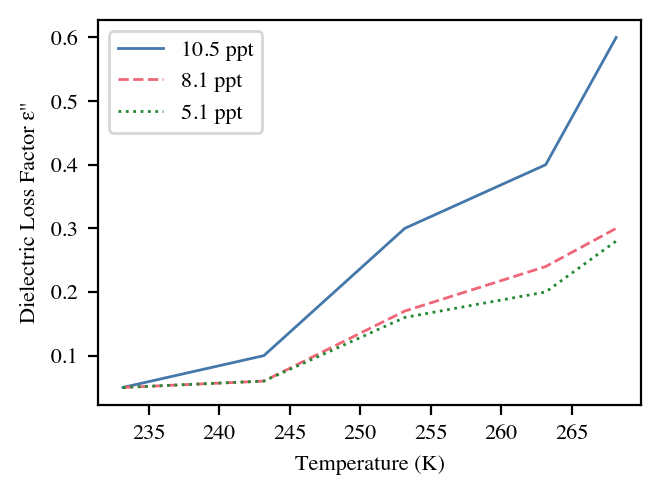

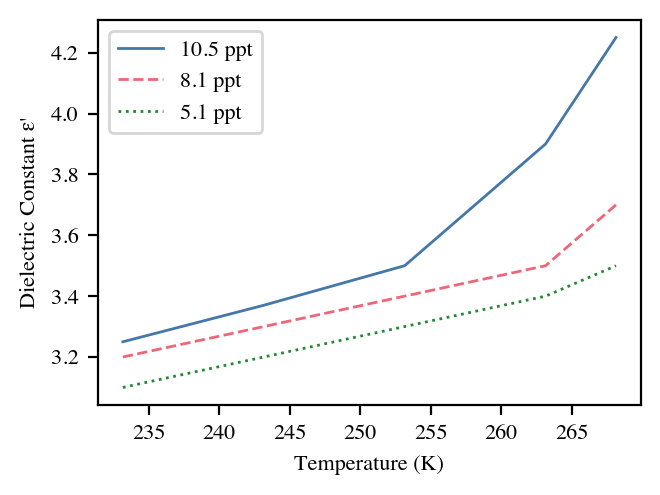

In [32]:
temperatures_fy = 273.15 + np.array([-40, -30, -20, -10, -5])
fy_ice_10p5ppt_lf = [0.05, 0.1, 0.3, 0.4, 0.6]
fy_ice_8p1ppt_lf = [0.05, 0.06, 0.17, 0.24, 0.3]
fy_ice_5p1ppt_lf = [0.05, 0.06, 0.16, 0.2, 0.28]

fy_ice_10p5ppt_dk = [3.25, 3.37, 3.5, 3.9, 4.25]
fy_ice_8p1ppt_dk = [3.2, 3.3, 3.4, 3.5, 3.7]
fy_ice_5p1ppt_dk = [3.1, 3.2, 3.3, 3.4, 3.5]

fig = plt.figure()

plt.plot(temperatures_fy, fy_ice_10p5ppt_lf, label='10.5 ppt')
plt.plot(temperatures_fy, fy_ice_8p1ppt_lf, label='8.1 ppt')
plt.plot(temperatures_fy, fy_ice_5p1ppt_lf, label='5.1 ppt')

plt.legend()

plt.xlabel('Temperature (K)')
plt.ylabel('Dielectric Loss Factor ε\'\'')
plt.show()

fig = plt.figure()

plt.plot(temperatures_fy, fy_ice_10p5ppt_dk, label='10.5 ppt')
plt.plot(temperatures_fy, fy_ice_8p1ppt_dk, label='8.1 ppt')
plt.plot(temperatures_fy, fy_ice_5p1ppt_dk, label='5.1 ppt')

plt.legend()

plt.xlabel('Temperature (K)')
plt.ylabel('Dielectric Constant ε\'')
plt.show()

In [33]:
np.interp(273.15-25, temperatures_fy, fy_ice_10p5ppt_lf)

0.19999999999999998

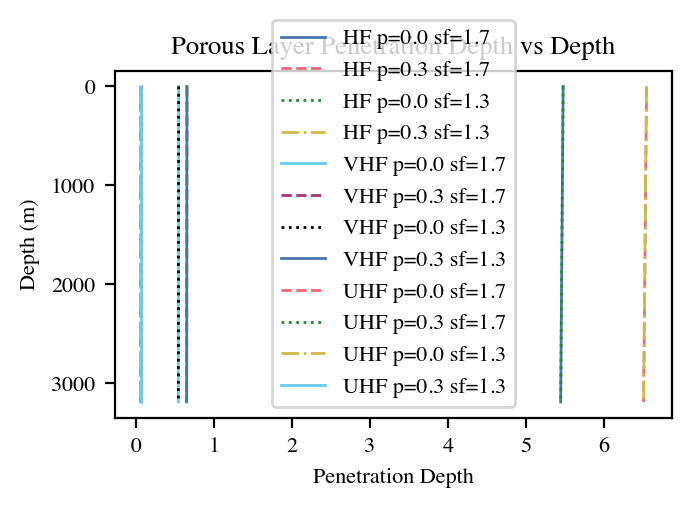

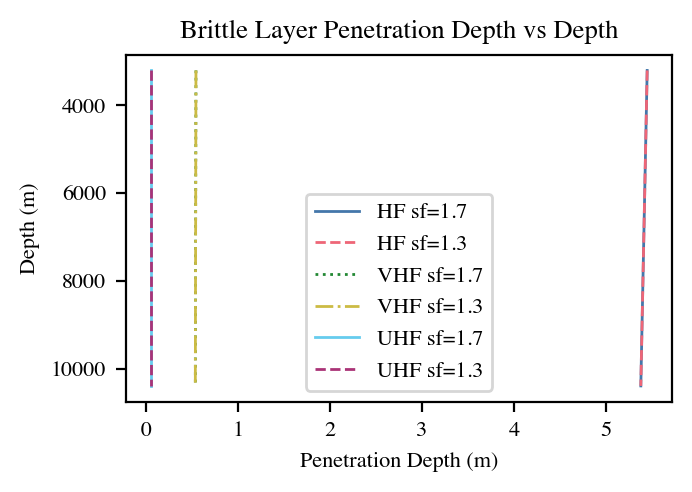

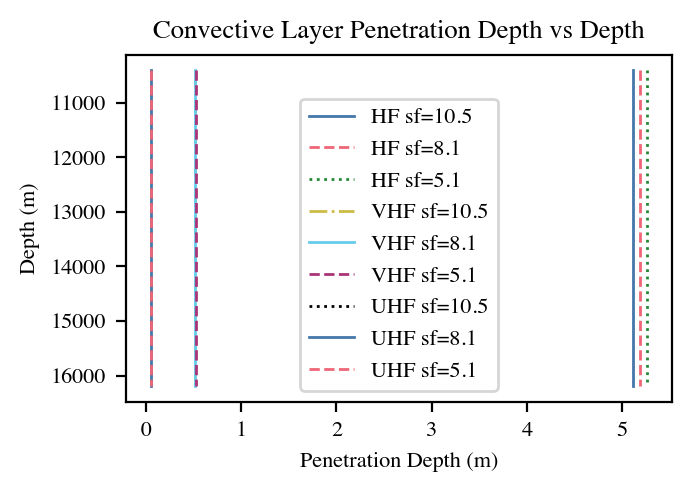

In [34]:
# Howell 2021 Model parameters
T_surf = 104 # K
T_cond_base = 230.4 # K
T_conv_iso = 251.6 # K
brittle_cryosphere_depth = 10.4 * 1000 # m
porous_cryosphere_depth = 3.2 * 1000 # m
surface_background_radiation_temperature = 10**4 # K
convective_cryosphere_depth = 5.8 * 1000 # m

T_melt = 273.13 # K

total_cryosphere_depth = brittle_cryosphere_depth + convective_cryosphere_depth

# Constants
c_0	= 299792458 # m/s
e = 2.718281828
epsilon_0 = 8.854E-12
mu_0 = 1.257E-06
k = 1.38E-23

# Propagation path modeling equations
def temperature_at_depth(depth):
    if depth > total_cryosphere_depth:
        return T_melt
    elif depth > brittle_cryosphere_depth:
        return T_conv_iso
    else:
        m, b = math_funcs.linear_fit(
            0, T_surf, 
            brittle_cryosphere_depth, T_cond_base)
        return m * depth + b

def ice_epsilon_relative_MW(T): # Matzler and Wegmuller model
    T = T - 273.13 # convert from Kelvin to Celsius
    real = 3.1884 + 0.00091*T
    imag = 10**(-3.0129 + 0.0123*T)
    return real - 1j*imag

# Values from Vant 1976 PhD Thesis, and read from graph in Hallikainen 1992
def ice_epsilon_relative_MY(T, carrier_frequency, salt_fraction_ppt, porosity=0): # Multiyear ice model
    # Estimate the loss factor from the dilectric model as a function of temperature
    boltzmann_model = lambda ae, t_0, epsilon_0, t: epsilon_0 * np.e**((ae* scipy.constants.electron_volt / scipy.constants.Boltzmann) \
        * (1 / (t_0) - (1 / (t))))
    loss_factor = 0
    if salt_fraction_ppt == 1.7:
        loss_factor = boltzmann_model(0.43, 273.15 - 5, 0.08, T)
    elif salt_fraction_ppt == 1.3:
        loss_factor = boltzmann_model(0.52,  273.15 - 5, 0.07, T)
    else:
        raise(ValueError('Salt fraction not found ' + str(salt_fraction_ppt)))

    # scale the
    #loss_factor = (loss_factor * 1e9) / carrier_frequency

    # Take the maximum value of loss factor from the Matzler and Wegmuller model or the Boltzmann model
    dielectric_constant = ice_epsilon_relative_MW(T)
    loss_factor = np.maximum(-1 * np.imag(dielectric_constant), loss_factor)

    epsilon_rel = np.real(dielectric_constant) - 1j * loss_factor

    # Scale the factor by the porosity of the outer shell using a simplistic linear model
    epsilon_rel = (1 - porosity) * epsilon_rel 

    return epsilon_rel

# Values from Vant 1976 PhD Thesis, and read from graph in Hallikainen 1992
temperatures_fy = 273.15 + np.array([-40, -30, -20, -10, -5])
fy_ice_10p5ppt_lf = [0.05, 0.1, 0.3, 0.4, 0.6]
fy_ice_8p1ppt_lf = [0.05, 0.06, 0.17, 0.24, 0.3]
fy_ice_5p1ppt_lf = [0.05, 0.06, 0.16, 0.2, 0.28]

fy_ice_10p5ppt_dk = [3.25, 3.37, 3.5, 3.9, 4.25]
fy_ice_8p1ppt_dk = [3.2, 3.3, 3.4, 3.5, 3.7]
fy_ice_5p1ppt_dk = [3.1, 3.2, 3.3, 3.4, 3.5]

def ice_epsilon_relative_FY(T,carrier_frequency, salt_fraction_ppt): # First year ice model
    """Estimate of the permittivity of ice using an empirical first year ice model

    :param T: Temperature in Kelvin
    :type T: float
    :param salt_fraction_ppt: Salt fraction in parts per thousand of mass
    :type salt_fraction_ppt: float
    :return: The relative dielectric constant with a real and imaginary part
    :rtype: complex float
    """
    loss_factor = 0
    if salt_fraction_ppt == 10.5:
        dielectric_constant = np.interp(T, temperatures_fy, fy_ice_10p5ppt_dk)
        loss_factor = np.interp(T, temperatures_fy, fy_ice_10p5ppt_lf)
    elif salt_fraction_ppt == 8.1:
        dielectric_constant = np.interp(T, temperatures_fy, fy_ice_8p1ppt_dk)
        loss_factor = np.interp(T, temperatures_fy, fy_ice_8p1ppt_lf)
    elif salt_fraction_ppt ==  5.1:
        dielectric_constant = np.interp(T, temperatures_fy, fy_ice_5p1ppt_dk)
        loss_factor = np.interp(T, temperatures_fy, fy_ice_5p1ppt_lf)
    else:
        raise(ValueError('Salt fraction not found ' + str(salt_fraction_ppt)))

    #loss_factor = (loss_factor * 1e9) / carrier_frequency

    epsilon_rel = np.real(dielectric_constant) - 1j * loss_factor

    return epsilon_rel

def ice_wave_number(carrier_frequency, epsilon_relative):
    return 2 * np.pi * carrier_frequency * np.sqrt(epsilon_0 * mu_0) * np.sqrt(epsilon_relative)

HF_carrier_frequency = 5e6
VHF_carrier_frequency = 50e6
UHF_carrier_frequency = 500e6

data = []
def append_to_data(data, d, f, band, T, por, sf, ep_rel):
    wave_number = ice_wave_number(f, ep_rel)
    space_loss = 10 * np.log10(((1 / (np.imag(wave_number) * 1 * 2))**2))
    path_loss = 10 * np.log10(np.e**(-2 * 1 * np.real(wave_number)))
    data.append({'depth':d, 'frequency':f, 'band':band, 'temperature':T, 'porosity':por, 'salt fraction':sf, 
        'epsilon_relative_real':np.real(ep_rel), 'epsilon_relative_imag':-1 * np.imag(ep_rel), 
        'Space loss per m': space_loss,
        'Path loss per m': path_loss,
        'Loss per m': space_loss + path_loss,
        'Penetration depth': 1 / np.real(wave_number)})

for d in np.arange(0, total_cryosphere_depth + 10, 10):
    for name, f in [('HF', HF_carrier_frequency), ('VHF', VHF_carrier_frequency), ('UHF', UHF_carrier_frequency)]:
        T = temperature_at_depth(d)
        append_to_data(data, d, f, name, T, 0, 0, ice_epsilon_relative_MW(T))
        if d < brittle_cryosphere_depth:
            for sf in [1.7, 1.3]:
                if d < porous_cryosphere_depth:
                    for p in [0, 0.3]:
                        append_to_data(data, d, f, name, T, p, sf, ice_epsilon_relative_MY(T, f, sf, p))
                else:
                    append_to_data(data, d, f, name, T, 0, sf, ice_epsilon_relative_MY(T, f, sf, 0))
        elif d < total_cryosphere_depth: # in the convective region
            for sf in [10.5, 8.1, 5.1]:
                append_to_data(data, d, f, name, T, 0, sf, ice_epsilon_relative_FY(T, f, sf))

df = pd.DataFrame(data)

# Plot porous layer
plt.figure()

porous_layer = df[df['depth'] < porous_cryosphere_depth]
for name, f in [('HF', HF_carrier_frequency), ('VHF', VHF_carrier_frequency), ('UHF', UHF_carrier_frequency)]:
    porous_layer_f = porous_layer[porous_layer['frequency']==f]
    for sf in [1.7, 1.3]:
        porous_layer_f_sf = porous_layer_f[porous_layer_f['salt fraction']==sf]
        for p in [0, 0.3]:
            porous_layer_f_sf_p = porous_layer_f_sf[porous_layer_f_sf['porosity']==p]
            plt.plot(porous_layer_f_sf_p['Penetration depth'], 
                porous_layer_f_sf_p['depth'],
                label=name + ' p=' + '{0:1.1f}'.format(p) + ' sf=' + '{0:1.1f}'.format(sf))

plt.title('Porous Layer Penetration Depth vs Depth')
plt.ylabel('Depth (m)')
plt.xlabel('Penetration Depth')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.legend()
plt.show()

# Plot brittle layer
plt.figure()

brittle_layer = df[df['depth'] > porous_cryosphere_depth]
brittle_layer = brittle_layer[brittle_layer['depth'] < brittle_cryosphere_depth]
for name, f in [('HF', HF_carrier_frequency), ('VHF', VHF_carrier_frequency), ('UHF', UHF_carrier_frequency)]:
    brittle_layer_f = brittle_layer[brittle_layer['frequency']==f]
    for sf in [1.7, 1.3]:
        brittle_layer_f_sf = brittle_layer_f[brittle_layer_f['salt fraction']==sf]
        plt.plot(brittle_layer_f_sf['Penetration depth'], 
            brittle_layer_f_sf['depth'],
            label=name + ' sf=' + '{0:1.1f}'.format(sf))

plt.title('Brittle Layer Penetration Depth vs Depth')
plt.ylabel('Depth (m)')
plt.xlabel('Penetration Depth (m)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.legend()
plt.show()

# Plot convective layer
plt.figure()

convective_layer = df[df['depth'] > brittle_cryosphere_depth]
for name, f in [('HF', HF_carrier_frequency), ('VHF', VHF_carrier_frequency), ('UHF', UHF_carrier_frequency)]:
    convective_layer_f = convective_layer[convective_layer['frequency']==f]
    for sf in [10.5, 8.1, 5.1]:
        convective_layer_f_sf = convective_layer_f[convective_layer_f['salt fraction']==sf]
        plt.plot(convective_layer_f_sf['Penetration depth'], 
            convective_layer_f_sf['depth'],
            label=name + ' sf=' + '{0:1.1f}'.format(sf))

plt.title('Convective Layer Penetration Depth vs Depth')
plt.ylabel('Depth (m)')
plt.xlabel('Penetration Depth (m)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.legend()
plt.show()



In [35]:
brittle_layer

,depth,frequency,band,temperature,porosity,salt fraction,epsilon_relative_real,epsilon_relative_imag,Space loss per m,Path loss per m,Loss per m,Penetration depth
3846,3210.0,5000000.0,HF,143.013846,0.0,1.7,3.069994,0.000024,116.730204,-1.595036,115.135169,5.445578
3847,3210.0,5000000.0,HF,143.013846,0.0,1.3,3.069994,0.000024,116.730204,-1.595036,115.135169,5.445578
3848,3210.0,50000000.0,VHF,143.013846,0.0,1.7,3.069994,0.000024,96.730204,-15.950355,80.779849,0.544558
3849,3210.0,50000000.0,VHF,143.013846,0.0,1.3,3.069994,0.000024,96.730204,-15.950355,80.779849,0.544558
3850,3210.0,500000000.0,UHF,143.013846,0.0,1.7,3.069994,0.000024,76.730204,-159.503553,-82.773349,0.054456
...,...,...,...,...,...,...,...,...,...,...,...,...
8155,10390.0,5000000.0,HF,230.278462,0.0,1.3,3.149405,0.001729,79.818553,-1.615533,78.203020,5.376485
8156,10390.0,50000000.0,VHF,230.278462,0.0,1.7,3.149405,0.003750,53.094989,-16.155333,36.939656,0.537648
8157,10390.0,50000000.0,VHF,230.278462,0.0,1.3,3.149405,0.001729,59.818553,-16.155331,43.663223,0.537649
8158,10390.0,500000000.0,UHF,230.278462,0.0,1.7,3.149405,0.003750,33.094989,-161.553331,-128.458342,0.053765


In [36]:
np.imag(ice_wave_number(f, 3 - 1j))

-2.985393899924744